가중치:
 item_condition_id_norm    0.003251
keyword_count_norm        0.232411
desc_len_norm             0.050612
shipping                  0.377315
is_brand                  0.336411
dtype: float64

---카테고리별 평균 신뢰도 점수 순위--
main_category
Beauty                    0.432602
Electronics               0.403522
Men                       0.396341
Women                     0.392011
Vintage & Collectibles    0.377458
Kids                      0.340160
Sports & Outdoors         0.307568
Other                     0.268871
Home                      0.255950
Handmade                  0.249634
Name: credibility_score_final, dtype: float64


/tmp/ipython-input-10-2693865229.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_credibility.index, y=sorted_credibility.values, palette='viridis')


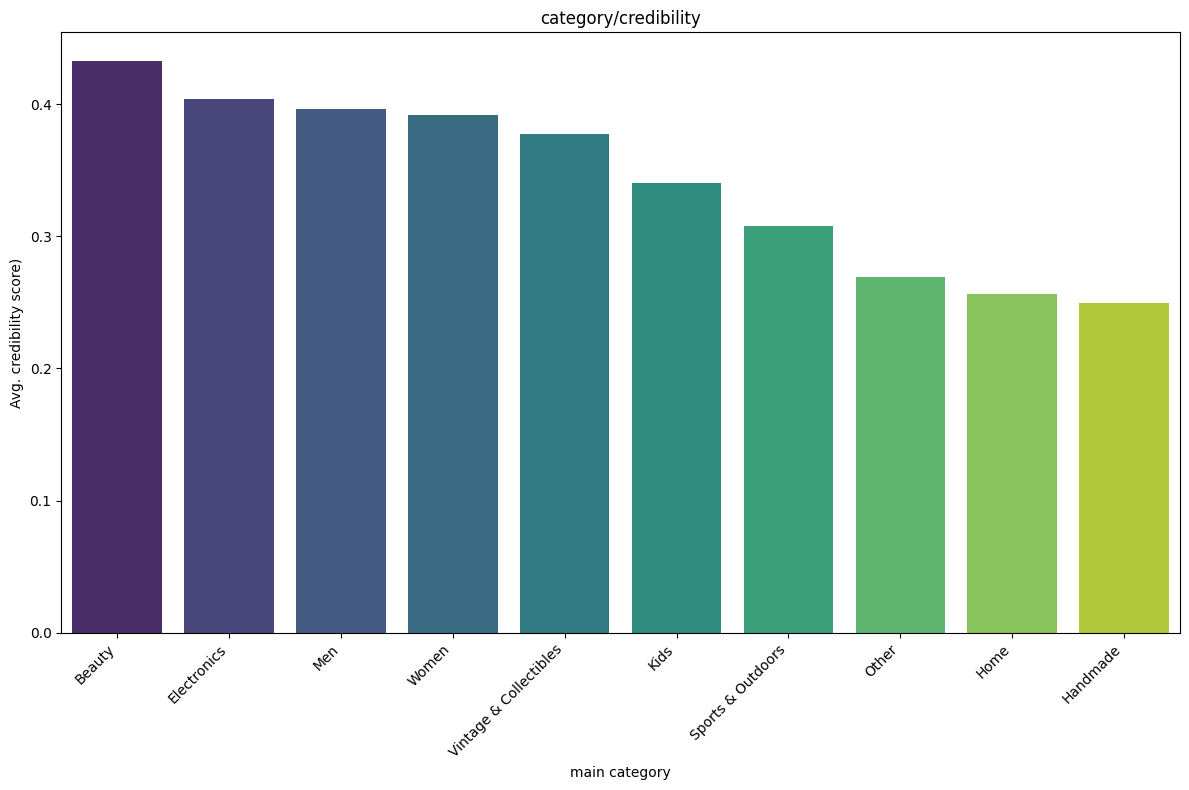

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

try:
    train = pd.read_csv('train.tsv', sep='\t')

    #가격 = 0인 행 제거
    train = train[train['price'] > 0]

    #category_name, item_description 결측치 행 제거
    train.dropna(subset=['category_name', 'item_description'], inplace=True)

    train_cleaned = train.copy()

    #피처 엔지니어링
    #카테고리
    split_categories = train_cleaned['category_name'].str.split('/', n=2, expand=True)
    train_cleaned['main_category'] = split_categories[0]
    train_cleaned['mid_category'] = split_categories[1]
    train_cleaned['sub_category'] = split_categories[2]

    #설명 길이
    train_cleaned['item_description'] = train_cleaned['item_description'].replace('No description yet', np.nan).fillna('')
    train_cleaned['desc_len'] = train_cleaned['item_description'].str.len()

    #키워드 개수
    keyword_list = ['authentic', 'new', 'nwt', 'mint', 'sealed', 'perfect', 'excellent']
    keyword_pattern = '|'.join(keyword_list)
    train_cleaned['keyword_count'] = train_cleaned['item_description'].str.lower().str.count(keyword_pattern)

    #브랜드 유무
    train_cleaned['is_brand'] = train_cleaned['brand_name'].notna().astype('int')

    #정규화
    features_to_normalize = ['desc_len', 'keyword_count', 'item_condition_id']
    scaler = MinMaxScaler()
    for feature in features_to_normalize:
        train_cleaned[f'{feature}_norm'] = scaler.fit_transform(train_cleaned[[feature]])

    #가중치 계산
    features_for_weights = ['item_condition_id_norm', 'keyword_count_norm', 'desc_len_norm', 'shipping', 'is_brand']
    correlations = train_cleaned[features_for_weights].corrwith(np.log1p(train_cleaned['price']))
    abs_correlations = correlations.abs()
    weights = abs_correlations / abs_correlations.sum()
    print("가중치:\n", weights)

    #신뢰도 점수
    train_cleaned['credibility_score_final'] = (
        (1 - train_cleaned['item_condition_id_norm']) * weights.get('item_condition_id_norm', 0) +
        train_cleaned['keyword_count_norm'] * weights.get('keyword_count_norm', 0) +
        train_cleaned['desc_len_norm'] * weights.get('desc_len_norm', 0) +
        train_cleaned['shipping'] * weights.get('shipping', 0) +
        train_cleaned['is_brand'] * weights.get('is_brand', 0)
    )

    #최종 분석: 카테고리별 평균 신뢰도 점수 계산 및 시각화

    #main_category로 그룹화하여 최종 신뢰도 점수의 평균 계산
    avg_credibility_by_category = train_cleaned.groupby('main_category')['credibility_score_final'].mean()

    # 점수가 높은 순으로 정렬
    sorted_credibility = avg_credibility_by_category.sort_values(ascending=False)

    print("\n---카테고리별 평균 신뢰도 점수 순위--")
    print(sorted_credibility)

    #시각화
    plt.figure(figsize=(12, 8))
    sns.barplot(x=sorted_credibility.index, y=sorted_credibility.values, palette='viridis')
    plt.title('category/credibility')
    plt.xlabel('main category')
    plt.ylabel('Avg. credibility score)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("파일 오류")
except KeyError as e:
    print(f"\n컬럼 오류: {e}")

In [ ]:
four_tier_edges = [0, 12, 50, 150, np.inf] # 0-12, 12-50, 50-150, 150-
four_tier_labels = ['Low', 'Mid', 'High', 'Luxury']

train_cleaned['price_tier_4'] = pd.cut(train_cleaned['price'], bins=four_tier_edges, labels=four_tier_labels, right=False)

print("4분할 가격 그룹별 기술 통계량")
print(train_cleaned.groupby('price_tier_4')['price'].describe().round(2))

4분할 가격 그룹별 기술 통계량
                 count    mean     std    min    25%    50%    75%     max
price_tier_4                                                              
Low           413643.0    8.03    2.20    3.0    7.0    8.0   10.0    11.5
Mid           902929.0   22.84    9.44   12.0   15.0   20.0   29.0    49.0
High          138471.0   75.14   23.93   50.0   56.0   66.0   86.0   149.0
Luxury         20298.0  252.83  159.61  150.0  167.0  201.0  271.0  2009.0


/tmp/ipython-input-11-2737492272.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(train_cleaned.groupby('price_tier_4')['price'].describe().round(2))


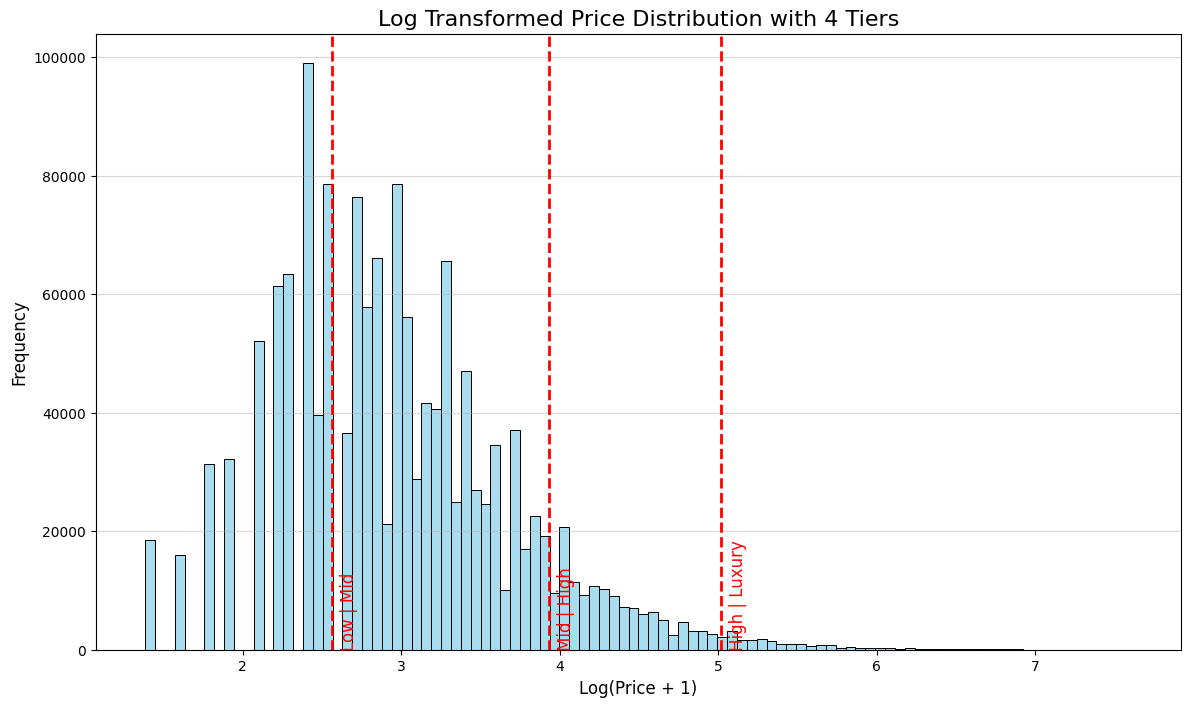

In [ ]:
if 'log_price' not in train_cleaned.columns:
    train_cleaned['log_price'] = np.log1p(train_cleaned['price'])

boundaries_log = [np.log1p(12), np.log1p(50), np.log1p(150)]
boundary_labels = ['Low | Mid', 'Mid | High', 'High | Luxury']

plt.figure(figsize=(14, 8))

sns.histplot(train_cleaned['log_price'], bins=100, alpha=0.7, color='skyblue')


for i, boundary in enumerate(boundaries_log):
    plt.axvline(x=boundary, color='red', linestyle='--', linewidth=2)
    plt.text(boundary + 0.05, 500, boundary_labels[i], rotation=90, color='red', fontsize=12)

plt.title('Log Transformed Price Distribution with 4 Tiers', fontsize=16)
plt.xlabel('Log(Price + 1)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, axis='y', alpha=0.5)

plt.show()

price_tier_4
Mid ($12-$50)      902929
Low ($0-$12)       413643
High ($50-$150)    138471
Luxury ($150+)      20298
Name: count, dtype: int64

4등급 가격 그룹별 프로파일링 결과
                 mean_price  median_price  avg_credibility_score  \
price_tier_4                                                       
Low ($0-$12)           8.03           8.0                   0.40   
Mid ($12-$50)         22.84          20.0                   0.36   
High ($50-$150)       75.14          66.0                   0.39   
Luxury ($150+)       252.83         201.0                   0.43   

                 keyword_rate  shipping_rate  brand_rate  avg_condition  \
price_tier_4                                                              
Low ($0-$12)             0.35           0.64        0.44           1.89   
Mid ($12-$50)            0.44           0.38        0.61           1.92   
High ($50-$150)          0.54           0.34        0.73           1.87   
Luxury ($150+)           0.58           0.36        

/tmp/ipython-input-13-338942853.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_group_profile_4tier = train_cleaned.groupby('price_tier_4').agg(


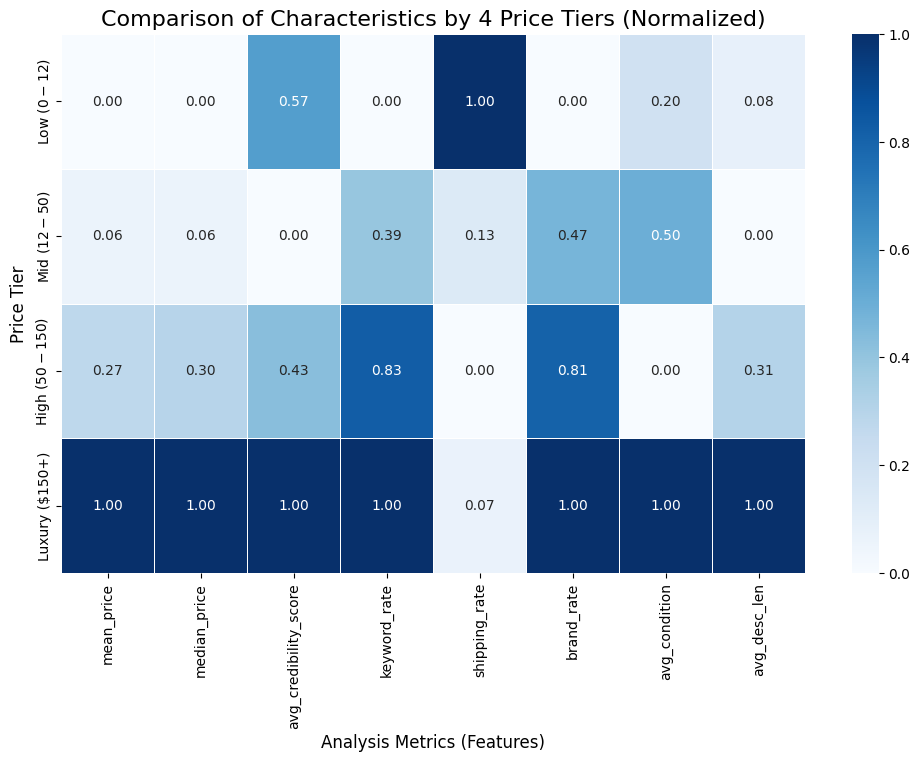

In [ ]:
four_tier_edges = [0, 12, 50, 150, np.inf]
four_tier_labels = ['Low ($0-$12)', 'Mid ($12-$50)', 'High ($50-$150)', 'Luxury ($150+)']

train_cleaned['price_tier_4'] = pd.cut(train_cleaned['price'], bins=four_tier_edges, labels=four_tier_labels, right=False)

print(train_cleaned['price_tier_4'].value_counts())

price_group_profile_4tier = train_cleaned.groupby('price_tier_4').agg(
    mean_price=('price', 'mean'),
    median_price=('price', 'median'),
    avg_credibility_score=('credibility_score_final', 'mean'),
    keyword_rate=('keyword_count', lambda x: (x > 0).mean()),
    shipping_rate=('shipping', 'mean'),
    brand_rate=('is_brand', 'mean'),
    avg_condition=('item_condition_id', 'mean'),
    avg_desc_len=('desc_len', 'mean'),
    item_count=('price', 'size')
).round(2)

print("\n4등급 가격 그룹별 프로파일링 결과")
print(price_group_profile_4tier)

scaler = MinMaxScaler()
profile_to_plot = price_group_profile_4tier.drop('item_count', axis=1)
profile_normalized = pd.DataFrame(scaler.fit_transform(profile_to_plot),
                                  index=profile_to_plot.index,
                                  columns=profile_to_plot.columns)

print("\n시각화를 위한 정규화된 프로파일링 결과")
print(profile_normalized)

#히트맵 시각화
plt.figure(figsize=(12, 7))
sns.heatmap(
    profile_normalized,
    annot=True,
    cmap='Blues',
    fmt='.2f',
    linewidths=.5
)
plt.title('Comparison of Characteristics by 4 Price Tiers (Normalized)', fontsize=16)
plt.xlabel('Analysis Metrics (Features)', fontsize=12)
plt.ylabel('Price Tier', fontsize=12)
plt.show()

/tmp/ipython-input-21-1914804380.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=positive_word_ratio.index, y=positive_word_ratio.values, palette=my_custom_palette) # 사용자 지정 색상 적용


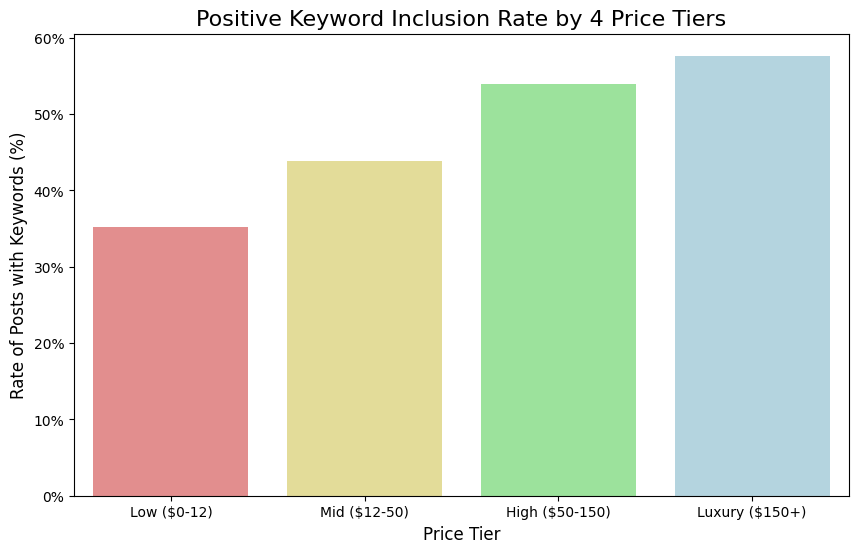

/tmp/ipython-input-21-1914804380.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='price_tier_4', y='credibility_score_final', data=train_cleaned, order=tier_order_4, palette=my_custom_palette) # 사용자 지정 색상 적용


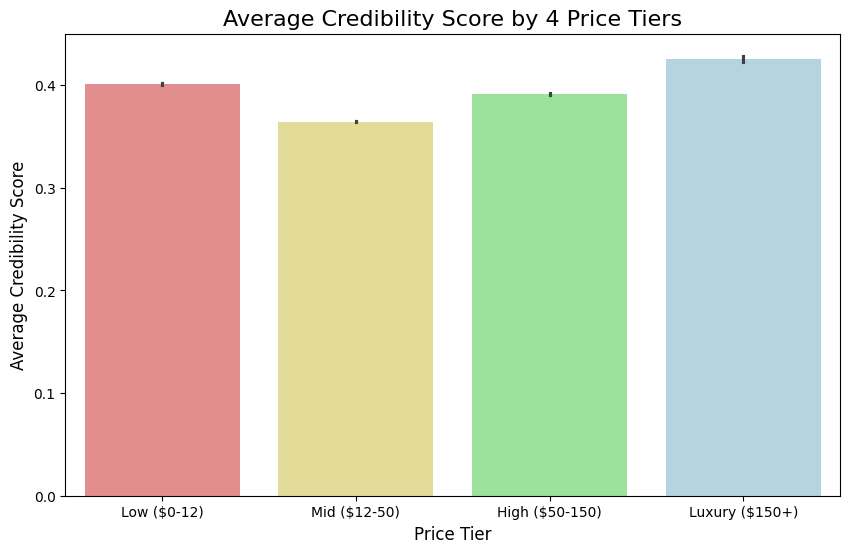

/tmp/ipython-input-21-1914804380.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='price_tier_4', y='item_condition_id', data=train_cleaned, order=tier_order_4, palette=my_custom_palette) # 사용자 지정 색상 적용


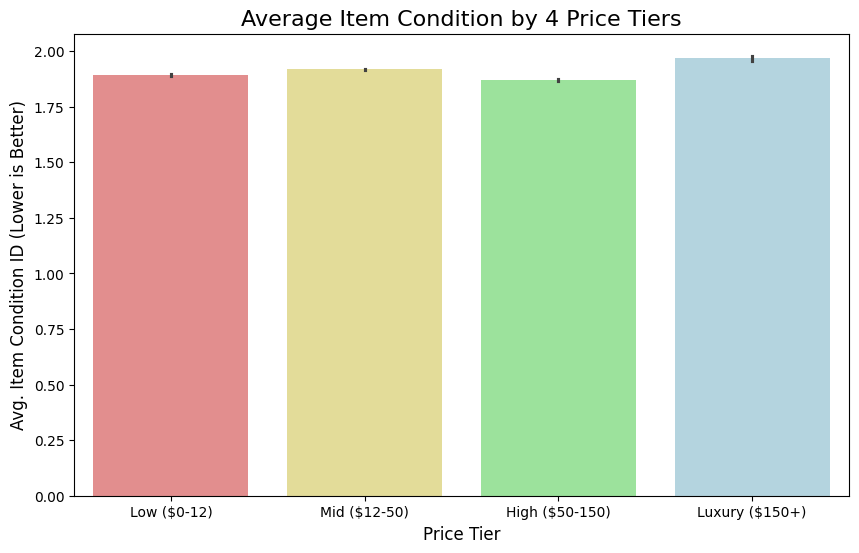

/tmp/ipython-input-21-1914804380.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='price_tier_4', y='desc_len', data=train_cleaned, order=tier_order_4, palette=my_custom_palette) # 사용자 지정 색상 적용


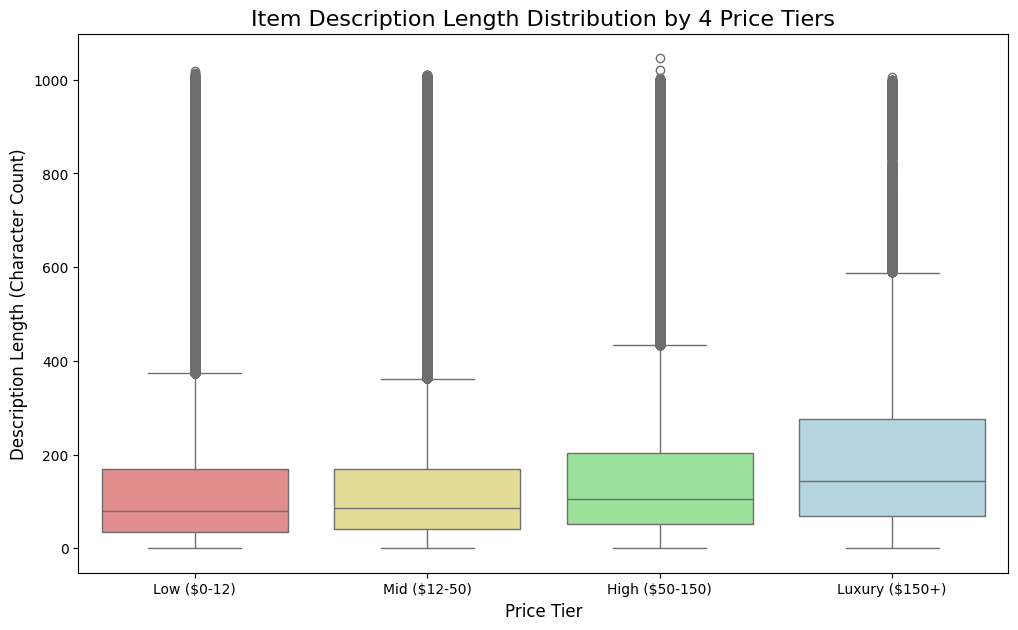

/tmp/ipython-input-21-1914804380.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=shipping_ratio.index, y=shipping_ratio.values, palette=my_custom_palette) # 사용자 지정 색상 적용


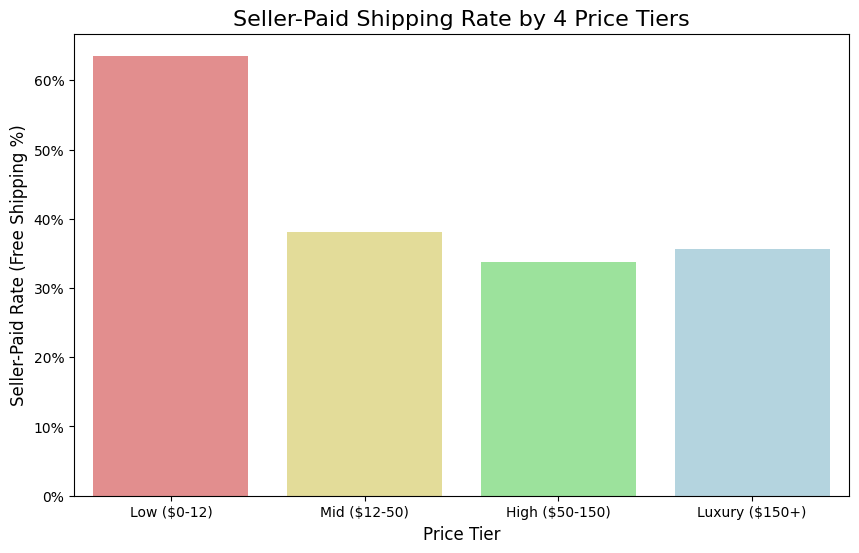

/tmp/ipython-input-21-1914804380.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=brand_rate.index, y=brand_rate.values, palette=my_custom_palette) # 사용자 지정 색상 적용


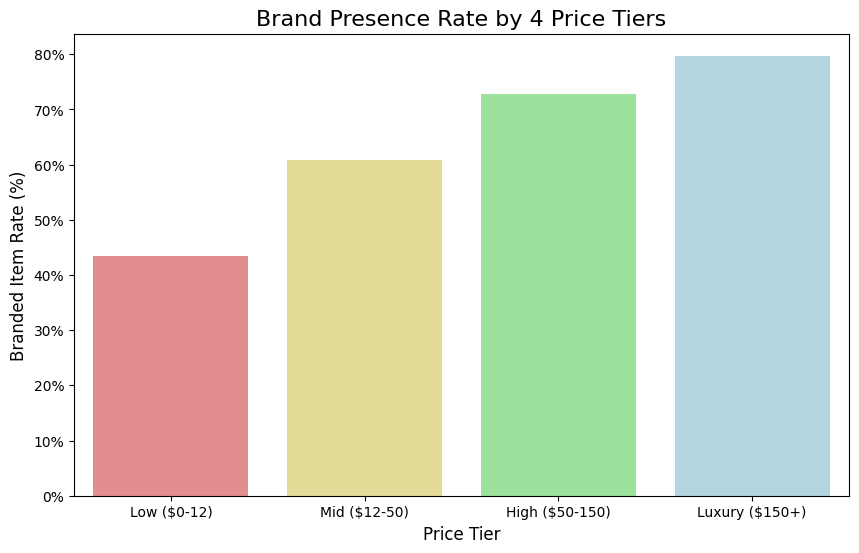

In [ ]:
from matplotlib.ticker import FuncFormatter

if 'price_tier_4' not in train_cleaned.columns:
    four_tier_edges = [0, 12, 50, 150, np.inf]
    four_tier_labels = ['Low ($0-12)', 'Mid ($12-50)', 'High ($50-150)', 'Luxury ($150+)']
    train_cleaned['price_tier_4'] = pd.cut(train_cleaned['price'], bins=four_tier_edges, labels=four_tier_labels, right=False)
    print("--- 4-Tier Price Grouping Complete ---")

#그룹별 분석 및 시각화
tier_order_4 = ['Low ($0-12)', 'Mid ($12-50)', 'High ($50-150)', 'Luxury ($150+)']

my_custom_palette = ['lightcoral', 'khaki', 'lightgreen', 'lightblue']

#가격 그룹별 신뢰도 키워드 포함 비율
plt.figure(figsize=(10, 6))
positive_word_ratio = train_cleaned.groupby('price_tier_4', observed=False)['keyword_count'].apply(lambda x: (x > 0).mean()).reindex(tier_order_4)
sns.barplot(x=positive_word_ratio.index, y=positive_word_ratio.values, palette=my_custom_palette) # 사용자 지정 색상 적용
plt.title('Positive Keyword Inclusion Rate by 4 Price Tiers', fontsize=16)
plt.ylabel('Rate of Posts with Keywords (%)', fontsize=12)
plt.xlabel('Price Tier', fontsize=12)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
plt.show()

#가격 그룹별 평균 신뢰도 점수
plt.figure(figsize=(10, 6))
sns.barplot(x='price_tier_4', y='credibility_score_final', data=train_cleaned, order=tier_order_4, palette=my_custom_palette) # 사용자 지정 색상 적용
plt.title('Average Credibility Score by 4 Price Tiers', fontsize=16)
plt.ylabel('Average Credibility Score', fontsize=12)
plt.xlabel('Price Tier', fontsize=12)
plt.show()

#가격 그룹별 평균 상품 상태
plt.figure(figsize=(10, 6))
sns.barplot(x='price_tier_4', y='item_condition_id', data=train_cleaned, order=tier_order_4, palette=my_custom_palette) # 사용자 지정 색상 적용
plt.title('Average Item Condition by 4 Price Tiers', fontsize=16)
plt.ylabel('Avg. Item Condition ID (Lower is Better)', fontsize=12)
plt.xlabel('Price Tier', fontsize=12)
plt.show()

#가격 그룹별 상품 설명 길이 분포
plt.figure(figsize=(12, 7))
sns.boxplot(x='price_tier_4', y='desc_len', data=train_cleaned, order=tier_order_4, palette=my_custom_palette) # 사용자 지정 색상 적용
plt.title('Item Description Length Distribution by 4 Price Tiers', fontsize=16)
plt.ylabel('Description Length (Character Count)', fontsize=12)
plt.xlabel('Price Tier', fontsize=12)
plt.show()

#가격 그룹별 판매자 배송비 부담 비율
plt.figure(figsize=(10, 6))
shipping_ratio = train_cleaned.groupby('price_tier_4', observed=False)['shipping'].mean().reindex(tier_order_4)
sns.barplot(x=shipping_ratio.index, y=shipping_ratio.values, palette=my_custom_palette) # 사용자 지정 색상 적용
plt.title('Seller-Paid Shipping Rate by 4 Price Tiers', fontsize=16)
plt.ylabel('Seller-Paid Rate (Free Shipping %)', fontsize=12)
plt.xlabel('Price Tier', fontsize=12)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
plt.show()

#가격 그룹별 브랜드 유무 비율
plt.figure(figsize=(10, 6))
brand_rate = train_cleaned.groupby('price_tier_4', observed=False)['is_brand'].mean().reindex(tier_order_4)
sns.barplot(x=brand_rate.index, y=brand_rate.values, palette=my_custom_palette) # 사용자 지정 색상 적용
plt.title('Brand Presence Rate by 4 Price Tiers', fontsize=16)
plt.ylabel('Branded Item Rate (%)', fontsize=12)
plt.xlabel('Price Tier', fontsize=12)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
plt.show()

테스트 데이터 MSE: 0.4571, OOB Score: 0.1789


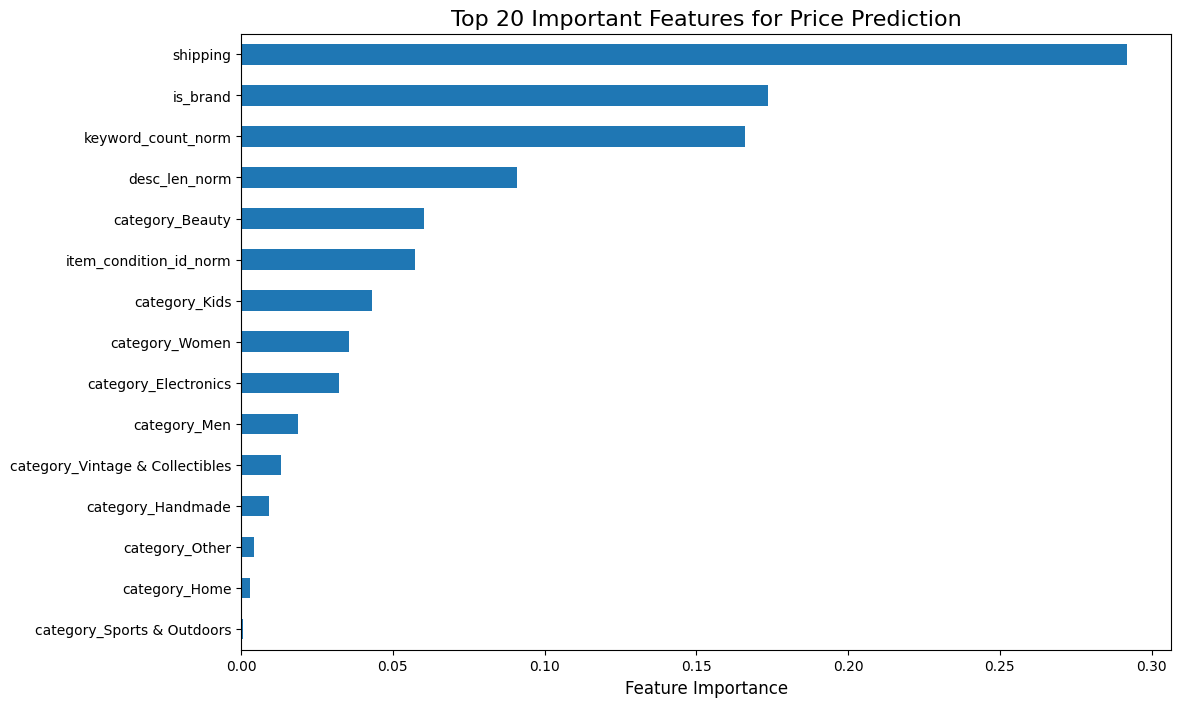

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

try:
    train = pd.read_csv('train.tsv', sep='\t')

    train = train[train['price'] > 0]
    train.dropna(subset=['category_name', 'item_description'], inplace=True) #결측치 제거
    train_cleaned = train.copy()

    #피처 엔지니어링
    #카테고리 분리
    split_categories = train_cleaned['category_name'].str.split('/', n=2, expand=True)
    train_cleaned['main_category'] = split_categories[0]

    #설명 길이, 키워드, 브랜드 유무 피처 생성
    train_cleaned['item_description'] = train_cleaned['item_description'].replace('No description yet', np.nan).fillna('')
    train_cleaned['desc_len'] = train_cleaned['item_description'].str.len()
    keyword_list = ['authentic', 'new', 'nwt', 'mint', 'sealed', 'perfect', 'excellent']
    keyword_pattern = '|'.join(keyword_list)
    train_cleaned['keyword_count'] = train_cleaned['item_description'].str.lower().str.count(keyword_pattern)
    train_cleaned['is_brand'] = train_cleaned['brand_name'].notna().astype('int')

    #정규화
    features_to_normalize = ['desc_len', 'keyword_count', 'item_condition_id']
    scaler = MinMaxScaler()
    for feature in features_to_normalize:
        train_cleaned[f'{feature}_norm'] = scaler.fit_transform(train_cleaned[[feature]])

    #OneHotEncoding
    main_category_dummies = pd.get_dummies(train_cleaned['main_category'], prefix='category')
    train_processed = pd.concat([train_cleaned, main_category_dummies], axis=1)

    final_features_list = [
        'item_condition_id_norm', 'desc_len_norm', 'keyword_count_norm',
        'shipping', 'is_brand'
    ] + list(main_category_dummies.columns)
    final_df = train_processed[final_features_list]

    #모델 학습 및 평가
    X = final_df
    y = np.log1p(train_processed['price'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10, oob_score=True)
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    print(f"테스트 데이터 MSE: {mse:.4f}, OOB Score: {model.oob_score_:.4f}")

    #변수 중요도 시각화
    feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)

    plt.figure(figsize=(12, 8))
    feature_importances.nlargest(20).sort_values(ascending=True).plot(kind='barh')
    plt.title('Top 20 Important Features for Price Prediction', fontsize=16)
    plt.xlabel('Feature Importance', fontsize=12)
    plt.show()

except FileNotFoundError:
    print("파일 오류")
except KeyError as e:
    print(f"\n컬럼 오류: {e}")

                      avg_predicted_price  shipping_rate  brand_rate  \
predicted_price_tier                                                   
Low ($0-12)                         10.59           1.00        0.12   
Mid ($12-50)                        20.47           0.39        0.62   
High ($50-150)                      63.08           0.06        0.99   
Luxury ($150+)                     159.68           0.00        1.00   

                      avg_condition  avg_desc_len  item_count  
predicted_price_tier                                           
Low ($0-12)                    1.57        167.18       64818  
Mid ($12-50)                   1.94        141.23      625560  
High ($50-150)                 2.59        343.04        2973  
Luxury ($150+)                 2.75        977.88           8  


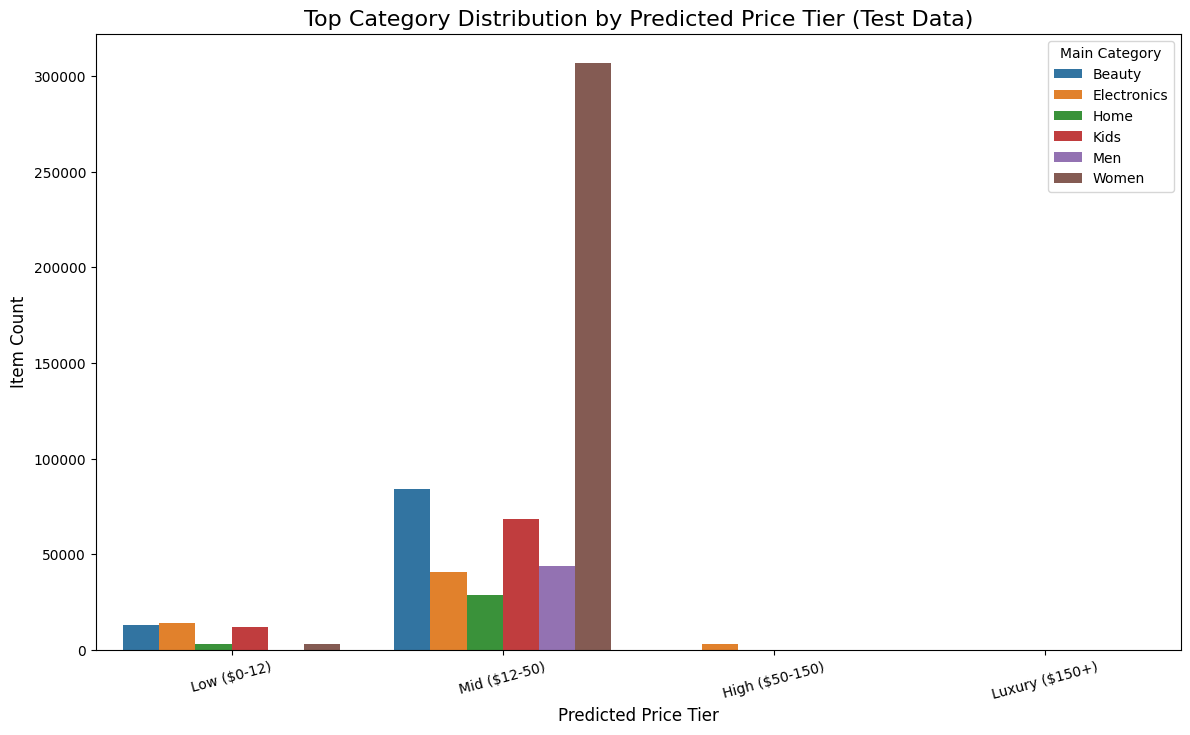

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from matplotlib.ticker import FuncFormatter

train_df = pd.read_csv('train.tsv', sep='\t')
test_df = pd.read_csv('test.tsv', sep='\t')

test_ids = test_df['test_id']
train_df = train_df[train_df['price'] > 0]
train_df.dropna(subset=['category_name'], inplace=True)

#학습/테스트 데이터 통합 및 피처 엔지니어링
test_df['price'] = np.nan
combined_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
combined_df['category_name'] = combined_df['category_name'].fillna('Unknown/Unknown/Unknown')
split_categories = combined_df['category_name'].str.split('/', n=2, expand=True)
combined_df['main_category'] = split_categories[0]

combined_df['item_description'] = combined_df['item_description'].fillna('')
combined_df['item_description'] = combined_df['item_description'].replace('No description yet', '')
combined_df['desc_len'] = combined_df['item_description'].str.len()

keyword_list = ['authentic', 'new', 'nwt', 'mint', 'sealed', 'perfect', 'excellent']
keyword_pattern = '|'.join(keyword_list)
combined_df['keyword_count'] = combined_df['item_description'].str.lower().str.count(keyword_pattern)

combined_df['is_brand'] = combined_df['brand_name'].notna().astype('int')

#정규화 및 원핫 인코딩
features_to_normalize = ['desc_len', 'keyword_count', 'item_condition_id']
scaler = MinMaxScaler()
for feature in features_to_normalize:
    combined_df[f'{feature}_norm'] = scaler.fit_transform(combined_df[[feature]])

main_category_dummies = pd.get_dummies(combined_df['main_category'], prefix='category')
combined_df = pd.concat([combined_df, main_category_dummies], axis=1)

#모델 학습/예측
final_train_df = combined_df[combined_df['price'].notna()]
final_test_df = combined_df[combined_df['price'].isna()]

final_features_list = [
    'item_condition_id_norm', 'desc_len_norm', 'keyword_count_norm', 'shipping', 'is_brand'
] + list(main_category_dummies.columns)

X_train_full = final_train_df[final_features_list]
y_train_full = np.log1p(final_train_df['price'])
X_submission = final_test_df[final_features_list]

final_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)
final_model.fit(X_train_full, y_train_full)
predictions_log = final_model.predict(X_submission)
predictions_final = np.expm1(predictions_log)


test_analysis_df = X_submission.copy()
test_analysis_df['price'] = predictions_final
cols_to_add = ['main_category', 'item_condition_id', 'desc_len', 'keyword_count', 'shipping', 'is_brand']
for col in cols_to_add:
    test_analysis_df[col] = final_test_df[col].values

#가격 기준 등급 분류
four_tier_edges = [0, 12, 50, 150, np.inf]
four_tier_labels = ['Low ($0-12)', 'Mid ($12-50)', 'High ($50-150)', 'Luxury ($150+)']
test_analysis_df['predicted_price_tier'] = pd.cut(test_analysis_df['price'], bins=four_tier_edges, labels=four_tier_labels, right=False)

#가격 등급별 특징 프로파일링 표
tier_order_4 = ['Low ($0-12)', 'Mid ($12-50)', 'High ($50-150)', 'Luxury ($150+)']
test_profile = test_analysis_df.groupby('predicted_price_tier', observed=True).agg(
        avg_predicted_price=('price', 'mean'),
        shipping_rate=('shipping', 'mean'),
        brand_rate=('is_brand', 'mean'),
        avg_condition=('item_condition_id', 'mean'),
        avg_desc_len=('desc_len', 'mean'),
        item_count=('price', 'size')
).round(2)
print(test_profile)

#가격 등급별 상위 카테고리 분포 시각화
category_dist = test_analysis_df.groupby(['predicted_price_tier', 'main_category'], observed=True).size().reset_index(name='count')
top_categories_overall = test_analysis_df['main_category'].value_counts().nlargest(6).index

plt.figure(figsize=(14, 8))
sns.barplot(
    data=category_dist[category_dist['main_category'].isin(top_categories_overall)],
    x='predicted_price_tier',
    y='count',
    hue='main_category')

plt.title('Top Category Distribution by Predicted Price Tier (Test Data)', fontsize=16)
plt.xlabel('Predicted Price Tier', fontsize=12)
plt.ylabel('Item Count', fontsize=12)
plt.xticks(rotation=15)
plt.legend(title='Main Category')
plt.show()

테스트 데이터에 대한 가격 예측 완료.

테스트 데이터의 가격 등급별 특징 프로파일링
                      avg_predicted_price  shipping_rate  brand_rate  \
predicted_price_tier                                                   
Low ($0-12)                         10.59           1.00        0.12   
Mid ($12-50)                        20.47           0.39        0.62   
High ($50-150)                      63.08           0.06        0.99   
Luxury ($150+)                     159.68           0.00        1.00   

                      avg_condition  avg_desc_len  item_count  
predicted_price_tier                                           
Low ($0-12)                    1.57        167.18       64818  
Mid ($12-50)                   1.94        141.23      625560  
High ($50-150)                 2.59        343.04        2973  
Luxury ($150+)                 2.75        977.88           8  

테스트 데이터의 가격 등급별 카테고리 분포 시각화


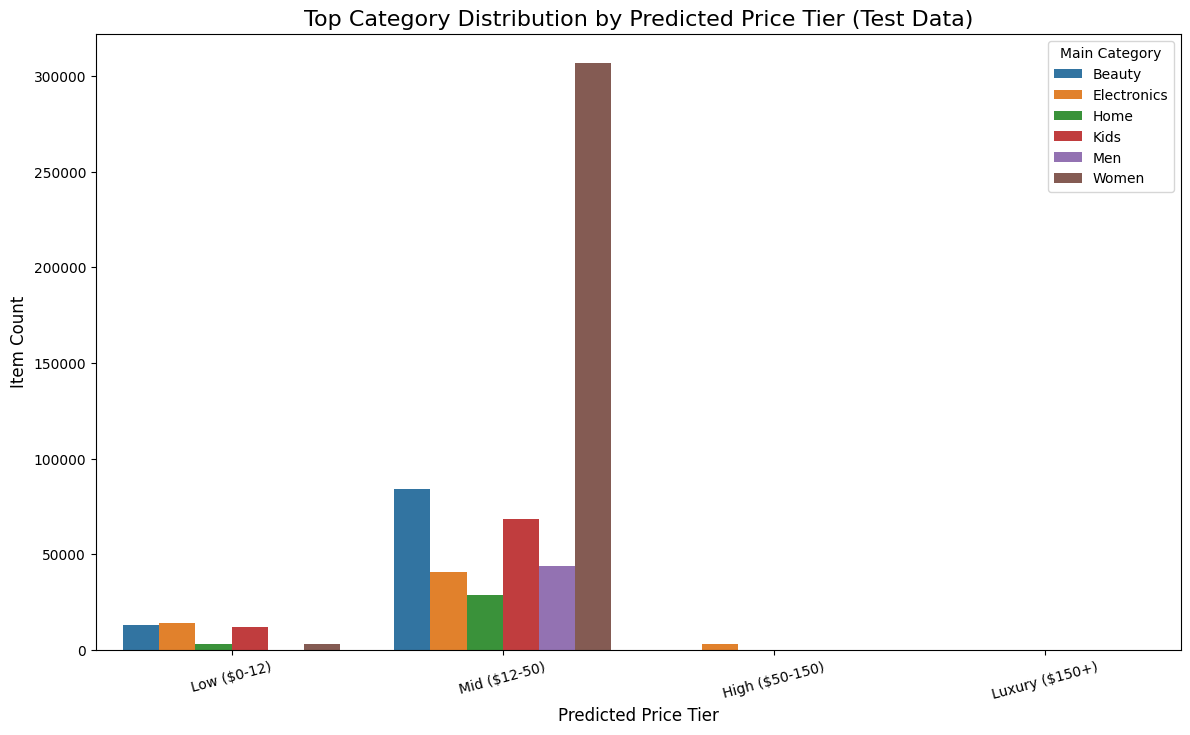

In [ ]:
try:
    train_df = pd.read_csv('train.tsv', sep='\t')
    test_df = pd.read_csv('test.tsv', sep='\t')

    test_ids = test_df['test_id'] # 제출용 ID 저장
    train_df = train_df[train_df['price'] > 0]
    train_df.dropna(subset=['category_name'], inplace=True)


    #피처 엔지니어링 시작
    test_df['price'] = np.nan
    combined_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

    combined_df['category_name'] = combined_df['category_name'].fillna('Unknown/Unknown/Unknown')
    split_categories = combined_df['category_name'].str.split('/', n=2, expand=True)
    combined_df['main_category'] = split_categories[0]

    combined_df['item_description'] = combined_df['item_description'].fillna('')
    combined_df['item_description'] = combined_df['item_description'].replace('No description yet', '')
    combined_df['desc_len'] = combined_df['item_description'].str.len()

    keyword_list = ['authentic', 'new', 'nwt', 'mint', 'sealed', 'perfect', 'excellent']
    keyword_pattern = '|'.join(keyword_list)
    combined_df['keyword_count'] = combined_df['item_description'].str.lower().str.count(keyword_pattern)

    combined_df['is_brand'] = combined_df['brand_name'].notna().astype('int')

    #정규화, 원핫 인코딩
    features_to_normalize = ['desc_len', 'keyword_count', 'item_condition_id']
    scaler = MinMaxScaler()
    for feature in features_to_normalize:
        combined_df[f'{feature}_norm'] = scaler.fit_transform(combined_df[[feature]])

    main_category_dummies = pd.get_dummies(combined_df['main_category'], prefix='category')
    combined_df = pd.concat([combined_df, main_category_dummies], axis=1)

    #모델 학습/예측
    final_train_df = combined_df[combined_df['price'].notna()]
    final_test_df = combined_df[combined_df['price'].isna()]

    final_features_list = [
        'item_condition_id_norm', 'desc_len_norm', 'keyword_count_norm', 'shipping', 'is_brand'
    ] + list(main_category_dummies.columns)

    X_train_full = final_train_df[final_features_list]
    y_train_full = np.log1p(final_train_df['price'])
    X_submission = final_test_df[final_features_list]

    final_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)
    final_model.fit(X_train_full, y_train_full)
    predictions_log = final_model.predict(X_submission)
    predictions_final = np.expm1(predictions_log)
    print("테스트 데이터에 대한 가격 예측 완료.")

    #최종 분석: 예측된 테스트 데이터 프로파일링, 시각화

    test_analysis_df = X_submission.copy()
    test_analysis_df['price'] = predictions_final
    cols_to_add = ['main_category', 'item_condition_id', 'desc_len', 'keyword_count']
    for col in cols_to_add:
        test_analysis_df[col] = final_test_df[col].values

    #가격 4등급 분류
    four_tier_edges = [0, 12, 50, 150, np.inf]
    four_tier_labels = ['Low ($0-12)', 'Mid ($12-50)', 'High ($50-150)', 'Luxury ($150+)']
    test_analysis_df['predicted_price_tier'] = pd.cut(test_analysis_df['price'], bins=four_tier_edges, labels=four_tier_labels, right=False)

    #가격 등급별 특징 프로파일링 표
    tier_order_4 = ['Low ($0-12)', 'Mid ($12-50)', 'High ($50-150)', 'Luxury ($150+)']

    test_profile = test_analysis_df.groupby('predicted_price_tier', observed=True).agg(
        avg_predicted_price=('price', 'mean'),
        shipping_rate=('shipping', 'mean'),
        brand_rate=('is_brand', 'mean'),
        avg_condition=('item_condition_id', 'mean'),
        avg_desc_len=('desc_len', 'mean'),
        item_count=('price', 'size')
    ).round(2)
    print(test_profile)

    #가격 등급별 상위 카테고리 분포 시각화
    top_categories_overall = test_analysis_df['main_category'].value_counts().nlargest(6).index

    category_dist = test_analysis_df.groupby(['predicted_price_tier', 'main_category'], observed=True).size().reset_index(name='count')

    plt.figure(figsize=(14, 8))
    sns.barplot(
        data=category_dist[category_dist['main_category'].isin(top_categories_overall)],
        x='predicted_price_tier',
        y='count',
        hue='main_category'
    )
    plt.title('Top Category Distribution by Predicted Price Tier (Test Data)', fontsize=16)
    plt.xlabel('Predicted Price Tier', fontsize=12)
    plt.ylabel('Item Count', fontsize=12)
    plt.xticks(rotation=15)
    plt.legend(title='Main Category')
    plt.show()

except FileNotFoundError:
    print("파일 오류")
except KeyError as e:
    print(f"\n컬럼 오류: {e}")

/tmp/ipython-input-21-785884022.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_df['category_name'].fillna('Unknown/Unknown/Unknown', inplace=True)
/tmp/ipython-input-21-785884022.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].me

                      avg_predicted_price  shipping_rate  brand_rate  \
predicted_price_tier                                                   
Low ($0-12)                         10.59           1.00        0.12   
Mid ($12-50)                        20.47           0.39        0.62   
High ($50-150)                      63.08           0.06        0.99   
Luxury ($150+)                     159.68           0.00        1.00   

                      avg_condition  avg_desc_len  item_count  
predicted_price_tier                                           
Low ($0-12)                    1.57        167.18       64818  
Mid ($12-50)                   1.94        141.23      625560  
High ($50-150)                 2.59        343.04        2973  
Luxury ($150+)                 2.75        977.88           8  


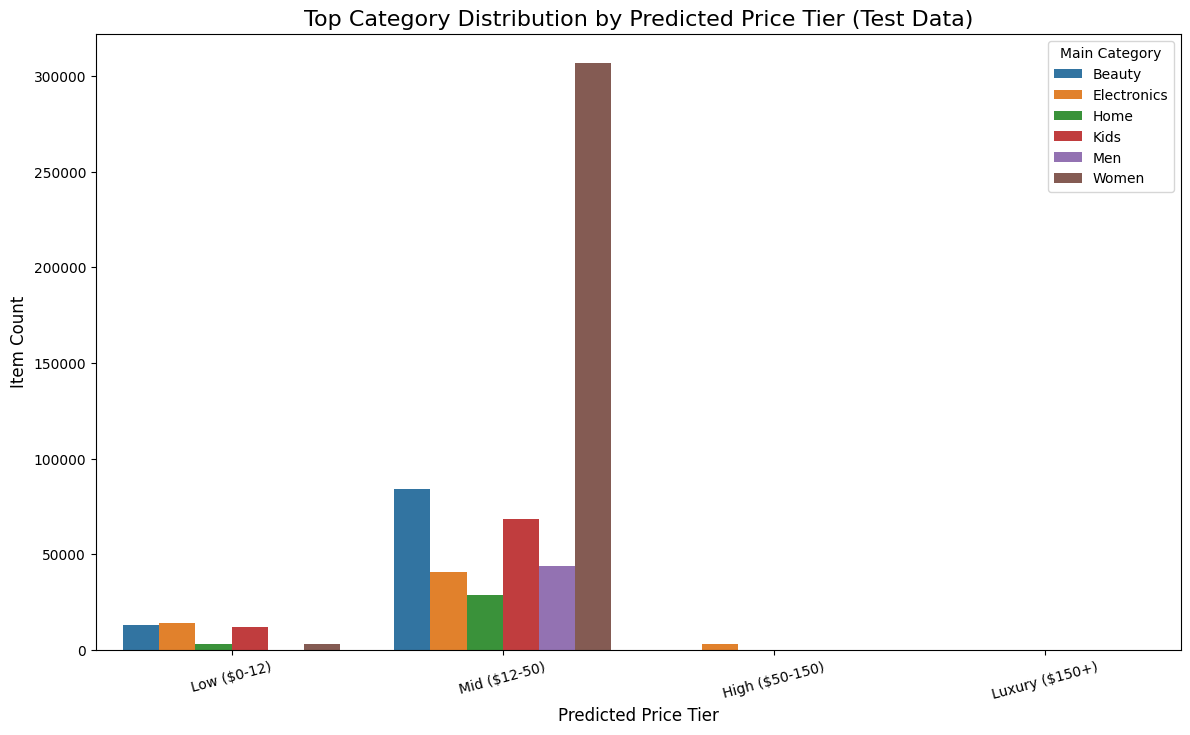

In [ ]:
try:
    train_df = pd.read_csv('train.tsv', sep='\t')
    test_df = pd.read_csv('test.tsv', sep='\t')

    test_ids = test_df['test_id']

    train_df = train_df[train_df['price'] > 0]
    train_df.dropna(subset=['category_name'], inplace=True)

    test_df['price'] = np.nan
    combined_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

    combined_df['category_name'].fillna('Unknown/Unknown/Unknown', inplace=True)
    split_categories = combined_df['category_name'].str.split('/', n=2, expand=True)
    combined_df['main_category'] = split_categories[0]


    combined_df['item_description'].fillna('', inplace=True)
    combined_df['item_description'] = combined_df['item_description'].replace('No description yet', '')
    combined_df['desc_len'] = combined_df['item_description'].str.len()


    keyword_list = ['authentic', 'new', 'nwt', 'mint', 'sealed', 'perfect', 'excellent']
    keyword_pattern = '|'.join(keyword_list)
    combined_df['keyword_count'] = combined_df['item_description'].str.lower().str.count(keyword_pattern)

    combined_df['is_brand'] = combined_df['brand_name'].notna().astype('int')


    features_to_normalize = ['desc_len', 'keyword_count', 'item_condition_id']
    scaler = MinMaxScaler()
    for feature in features_to_normalize:
        combined_df[f'{feature}_norm'] = scaler.fit_transform(combined_df[[feature]])

    main_category_dummies = pd.get_dummies(combined_df['main_category'], prefix='category')
    combined_df = pd.concat([combined_df, main_category_dummies], axis=1)


    #모델 학습/예측
    final_train_df = combined_df[combined_df['price'].notna()]
    final_test_df = combined_df[combined_df['price'].isna()]

    final_features_list = [
        'item_condition_id_norm', 'desc_len_norm', 'keyword_count_norm', 'shipping', 'is_brand'
    ] + list(main_category_dummies.columns)

    X_train_full = final_train_df[final_features_list]
    y_train_full = np.log1p(final_train_df['price'])
    X_submission = final_test_df[final_features_list]

    final_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)
    final_model.fit(X_train_full, y_train_full)
    predictions_log = final_model.predict(X_submission)
    predictions_final = np.expm1(predictions_log)



    #최종 분석: 프로파일링
    test_analysis_df = X_submission.copy()
    test_analysis_df['price'] = predictions_final
    test_analysis_df['main_category'] = final_test_df['main_category']
    test_analysis_df['item_condition_id'] = final_test_df['item_condition_id']
    test_analysis_df['desc_len'] = final_test_df['desc_len']


    four_tier_edges = [0, 12, 50, 150, np.inf]
    four_tier_labels = ['Low ($0-12)', 'Mid ($12-50)', 'High ($50-150)', 'Luxury ($150+)']
    test_analysis_df['predicted_price_tier'] = pd.cut(test_analysis_df['price'], bins=four_tier_edges, labels=four_tier_labels, right=False)

    #가격 등급별 특징 프로파일링 표 출력
    tier_order_4 = ['Low ($0-12)', 'Mid ($12-50)', 'High ($50-150)', 'Luxury ($150+)']
    test_profile = test_analysis_df.groupby('predicted_price_tier').agg(
        avg_predicted_price=('price', 'mean'),
        shipping_rate=('shipping', 'mean'),
        brand_rate=('is_brand', 'mean'),
        avg_condition=('item_condition_id', 'mean'),
        avg_desc_len=('desc_len', 'mean'),
        item_count=('price', 'size')
    ).round(2)
    print(test_profile)

    #가격 등급별 상위 카테고리 분포 시각화
    top_categories_overall = test_analysis_df['main_category'].value_counts().nlargest(6).index

    category_dist = test_analysis_df.groupby(['predicted_price_tier', 'main_category']).size().reset_index(name='count')

    plt.figure(figsize=(14, 8))
    sns.barplot(
        data=category_dist[category_dist['main_category'].isin(top_categories_overall)],
        x='predicted_price_tier',
        y='count',
        hue='main_category'
    )
    plt.title('Top Category Distribution by Predicted Price Tier (Test Data)', fontsize=16)
    plt.xlabel('Predicted Price Tier', fontsize=12)
    plt.ylabel('Item Count', fontsize=12)
    plt.xticks(rotation=15)
    plt.legend(title='Main Category')
    plt.show()

except FileNotFoundError:
    print("파일 오류")
except KeyError as e:
    print(f"\n컬럼 오류: {e}")


가격 등급별 특징 프로파일링
                      avg_predicted_price  shipping_rate  brand_rate  \
predicted_price_tier                                                   
Low ($0-12)                         10.59           1.00        0.12   
Mid ($12-50)                        20.47           0.39        0.62   
High ($50-150)                      63.08           0.06        0.99   
Luxury ($150+)                     159.68           0.00        1.00   

                      avg_condition  avg_desc_len  avg_keyword_count  
predicted_price_tier                                                  
Low ($0-12)                    1.57        167.18               0.15  
Mid ($12-50)                   1.94        141.23               0.57  
High ($50-150)                 2.59        343.04               1.09  
Luxury ($150+)                 2.75        977.88               2.75  


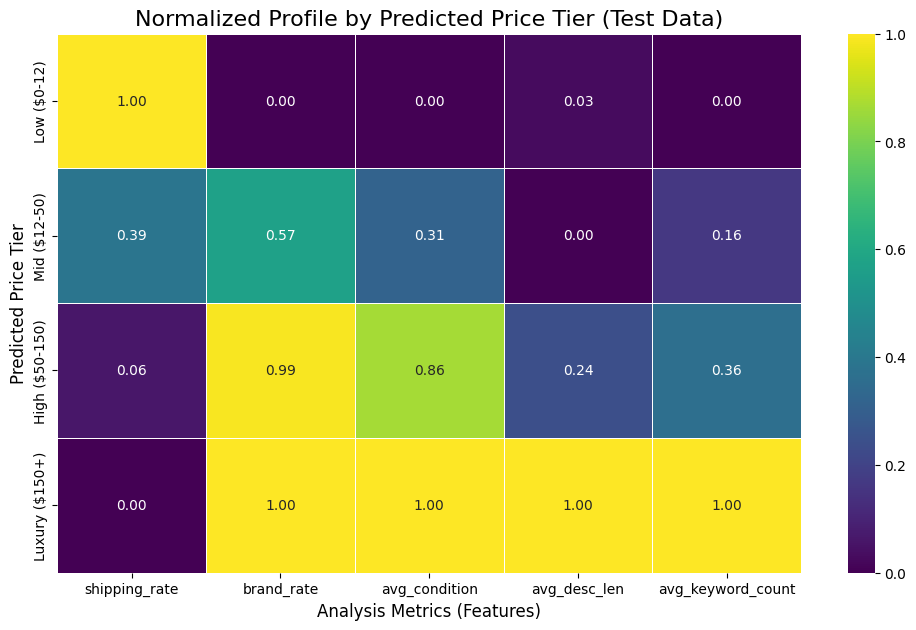

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from matplotlib.ticker import FuncFormatter

test_analysis_df = X_submission.copy()

test_analysis_df['price'] = predictions_final

cols_to_add = ['main_category', 'item_condition_id', 'desc_len', 'keyword_count']
for col in cols_to_add:
    test_analysis_df[col] = final_test_df[col].values


#예측된 가격 기준 등급 분류
four_tier_edges = [0, 12, 50, 150, np.inf]
four_tier_labels = ['Low ($0-12)', 'Mid ($12-50)', 'High ($50-150)', 'Luxury ($150+)']
test_analysis_df['predicted_price_tier'] = pd.cut(test_analysis_df['price'], bins=four_tier_edges, labels=four_tier_labels, right=False)


#가격 등급별 특징 프로파일링 표
print("\n가격 등급별 특징 프로파일링")
tier_order_4 = ['Low ($0-12)', 'Mid ($12-50)', 'High ($50-150)', 'Luxury ($150+)']

test_profile = test_analysis_df.groupby('predicted_price_tier', observed=True).agg(
    avg_predicted_price=('price', 'mean'),
    shipping_rate=('shipping', 'mean'),
    brand_rate=('is_brand', 'mean'),
    avg_condition=('item_condition_id', 'mean'),
    avg_desc_len=('desc_len', 'mean'),
    avg_keyword_count=('keyword_count', 'mean')
).round(2)
print(test_profile)


#프로파일링 결과 시각화
#정규화
scaler = MinMaxScaler()
profile_to_plot = test_profile.drop('avg_predicted_price', axis=1)
profile_normalized = pd.DataFrame(scaler.fit_transform(profile_to_plot),
                                  index=profile_to_plot.index,
                                  columns=profile_to_plot.columns)

plt.figure(figsize=(12, 7))
sns.heatmap(
    profile_normalized,
    annot=True,
    cmap='viridis',
    fmt='.2f',
    linewidths=.5
)
plt.title('Normalized Profile by Predicted Price Tier (Test Data)', fontsize=16)
plt.xlabel('Analysis Metrics (Features)', fontsize=12)
plt.ylabel('Predicted Price Tier', fontsize=12)
plt.show()

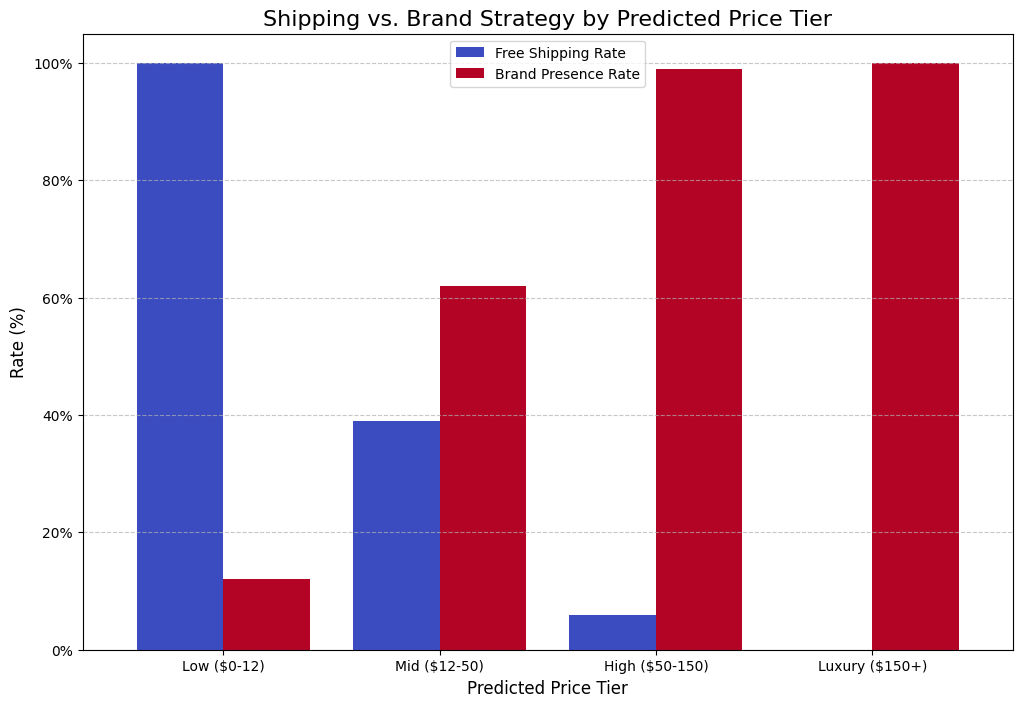

In [ ]:
#배송/브랜드 유무 비교 (test.tsv)
strategy_df = test_profile[['shipping_rate', 'brand_rate']]


ax = strategy_df.plot(
    kind='bar',
    figsize=(12, 8),
    width=0.8,
    colormap='coolwarm'
)


plt.title('Shipping vs. Brand Strategy by Predicted Price Tier', fontsize=16)
plt.xlabel('Predicted Price Tier', fontsize=12)
plt.ylabel('Rate (%)', fontsize=12)
plt.xticks(rotation=0)

ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))

ax.legend(['Free Shipping Rate', 'Brand Presence Rate'])

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

/tmp/ipython-input-20-2660936349.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_dist = test_analysis_df.groupby(['predicted_price_tier', 'main_category']).size().reset_index(name='count')


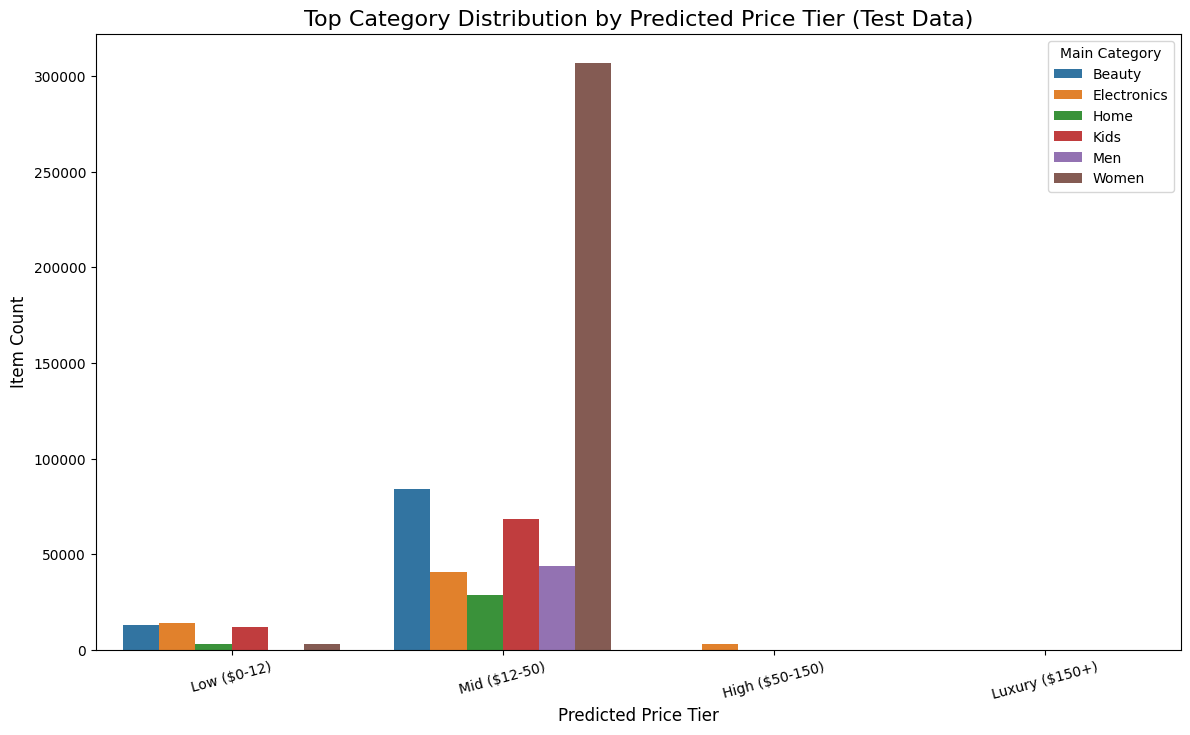

In [ ]:
try:
    category_dist = test_analysis_df.groupby(['predicted_price_tier', 'main_category']).size().reset_index(name='count')
    top_categories_overall = test_analysis_df['main_category'].value_counts().nlargest(6).index

    plt.figure(figsize=(14, 8))
    sns.barplot(
        data=category_dist[category_dist['main_category'].isin(top_categories_overall)],
        x='predicted_price_tier',
        y='count',
        hue='main_category'
    )
    plt.title('Top Category Distribution by Predicted Price Tier (Test Data)', fontsize=16)
    plt.xlabel('Predicted Price Tier', fontsize=12)
    plt.ylabel('Item Count', fontsize=12)
    plt.xticks(rotation=15)
    plt.legend(title='Main Category')
    plt.show()

except FileNotFoundError:
    print("파일 오류")
except KeyError as e:
    print(f"\n컬럼 오류: {e}")